# Tutorial 4 : Attentive Neural Processes Variants - 1D GP Data

Last Update : 12 June 2019

**Aim**: 
- Training a simple [Attentive Neural Process] (ANP)
- Showing how to use the library to build more complicated models

**Nota Bene:**
- The majority of the work below does not follow any paper
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].

[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

In this notebook I only look at the periodic and mattern kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for all parameters. 

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [7]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, add_flat_input, DeepMLP
from skssl.transformers.neuralproc.datasplit import context_target_split

In [8]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [9]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def get_attn_bloc(attention=attention):
    return lambda *args: SelfAttentionBlock(*args, attention=attention)

def init_models():
    return {"Conditional_ANP":AttentiveNeuralProcess(X_DIM, Y_DIM,
                                  r_dim=R_DIM,
                                  get_cntxt_trgt=get_cntxt_trgt,
                                  encoded_path="deterministic"),
     
     "Multihead_ANP":AttentiveNeuralProcess(X_DIM, Y_DIM,
                                  r_dim=R_DIM,
                                  get_cntxt_trgt=get_cntxt_trgt,
                                  attention="multihead", 
                                  encoded_path="both") ,
     
     "Sinusoidal_ANP":AttentiveNeuralProcess(X_DIM, Y_DIM,
                                  XEncoder=SinusoidalEncodings, # sinusoidal encodings
                                  r_dim=R_DIM,
                                  get_cntxt_trgt=get_cntxt_trgt,
                                  encoded_path="both") ,
     
     "SelfAttn_Enc_ANP":AttentiveNeuralProcess(X_DIM, Y_DIM,
                                  XYEncoder=SelfAttentionBlock,  # self attention encoder 
                                  r_dim=R_DIM,
                                  get_cntxt_trgt=get_cntxt_trgt,
                                  encoded_path="both") ,
     
     "SelfAttn_Dec_ANP":AttentiveNeuralProcess(X_DIM, Y_DIM,
                                  Decoder=SelfAttentionBlock,  # self attention decoder 
                                  r_dim=R_DIM,
                                  get_cntxt_trgt=get_cntxt_trgt,
                                  encoded_path="both"),
     
     "Transformer Process":AttentiveNeuralProcess(X_DIM, Y_DIM,
                                  XEncoder=SinusoidalEncodings, # sinusoidal encodings
                                  XYEncoder=SelfAttentionBlock,  # self attention encoder 
                                  Decoder=SelfAttentionBlock,  # self attention decoder 
                                  r_dim=R_DIM,
                                  get_cntxt_trgt=get_cntxt_trgt,
                                  attention="multihead", 
                                  encoded_path="both")}

# initialize all model for each dataset
data_models = {name: (init_models(), data) 
               for name, data in datasets.items()}

/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [11]:
from utils.helpers import count_parameters

In [12]:
for k, (models, dataset) in data_models.items():
    for name, model in models.items():
        print("N Param for {}:".format(name), count_parameters(model))
    break

N Param for Conditional_ANP: 136642
N Param for Multihead_ANP: 284738
N Param for Sinusoidal_ANP: 214786
N Param for SelfAttn_Enc_ANP: 157186
N Param for SelfAttn_Dec_ANP: 153154


## Training

In [15]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

In [16]:
N_EPOCHS = 50
# using a small batch size seems important, probably because
# use fix amount of context in batch, and with attention you 
# don't have aggregation => the number of context points
# changes the attention mechanism (the softmax) => use small
# to have many different (they use 16)
BATCH_SIZE = 16 
is_RETRAIN = True # if false load precomputed

In [17]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/anp_dotattn_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=5e-4, # smaller lr needed with attention
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    else:
        model.initialize()
        model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1       84.4105     +  66.5563


      2       32.2578     +  64.8441


      3        9.0177     +  66.5487


      4       -5.8768     +  67.3840


      5      -15.0423     +  66.0244


      6      -23.0336     +  67.4013


      7      -28.3600     +  67.8562


      8      -36.1427     +  69.1079


      9      -37.9392     +  66.5365


     10      -42.9627     +  65.6358


     11      -45.6621     +  58.9423


     12      -46.3852     +  55.7505


     13      -46.9894     +  55.2236


     14      -52.3374     +  57.8597


     15      -53.4041     +  58.0467


     16      -52.5553        59.3690


     17      -56.9770     +  58.7664


     18      -56.4495        59.9538



--- Training periodic ---




--- Training non-stationary ---




--- Training matern ---



# Trained Prior

In [20]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 1.5096116518974303
std: 1.1027962595224379
std: 2.611470868587493
std: 1.1799834859371185


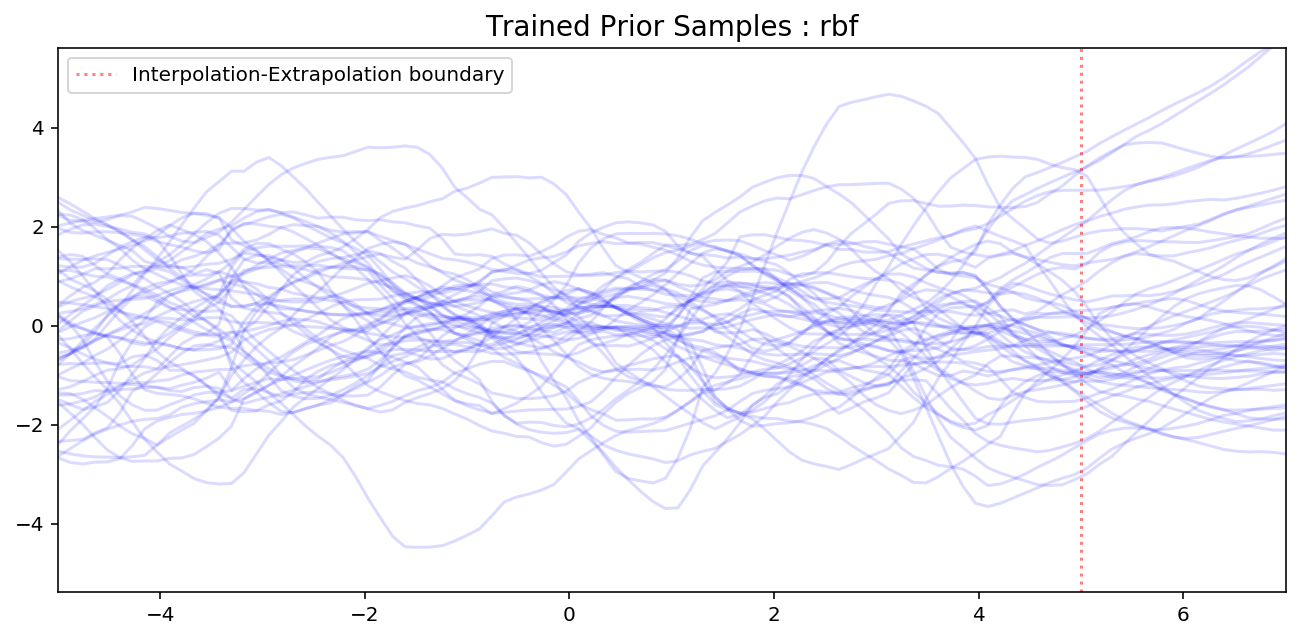

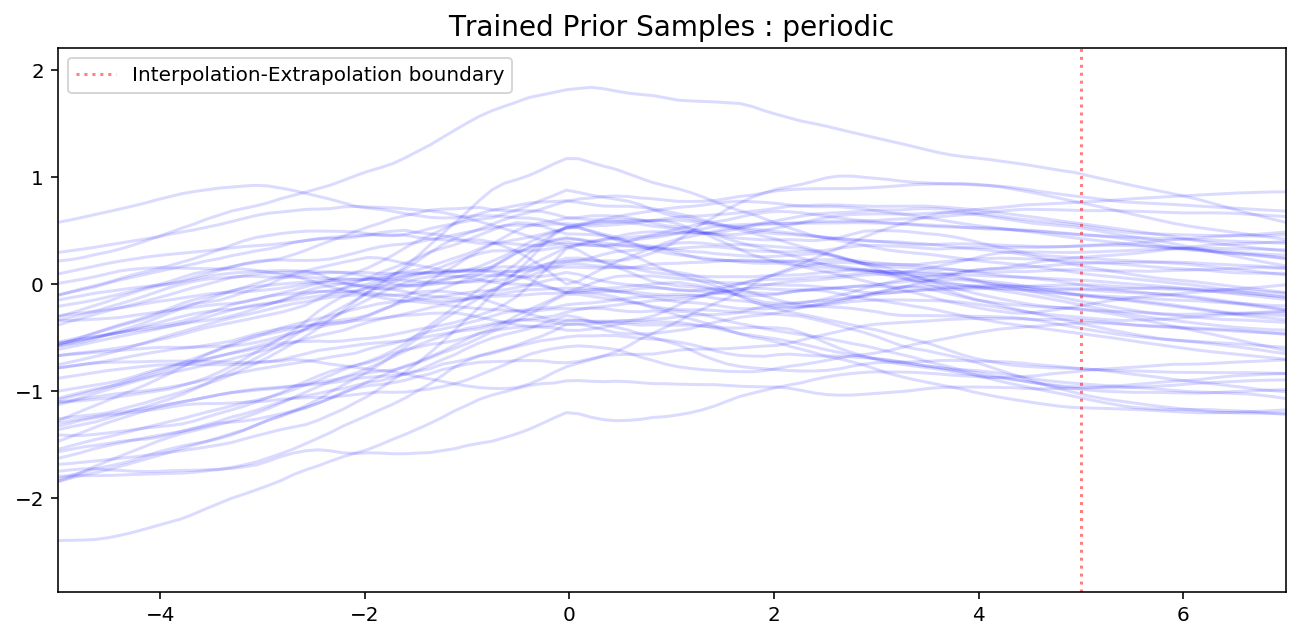

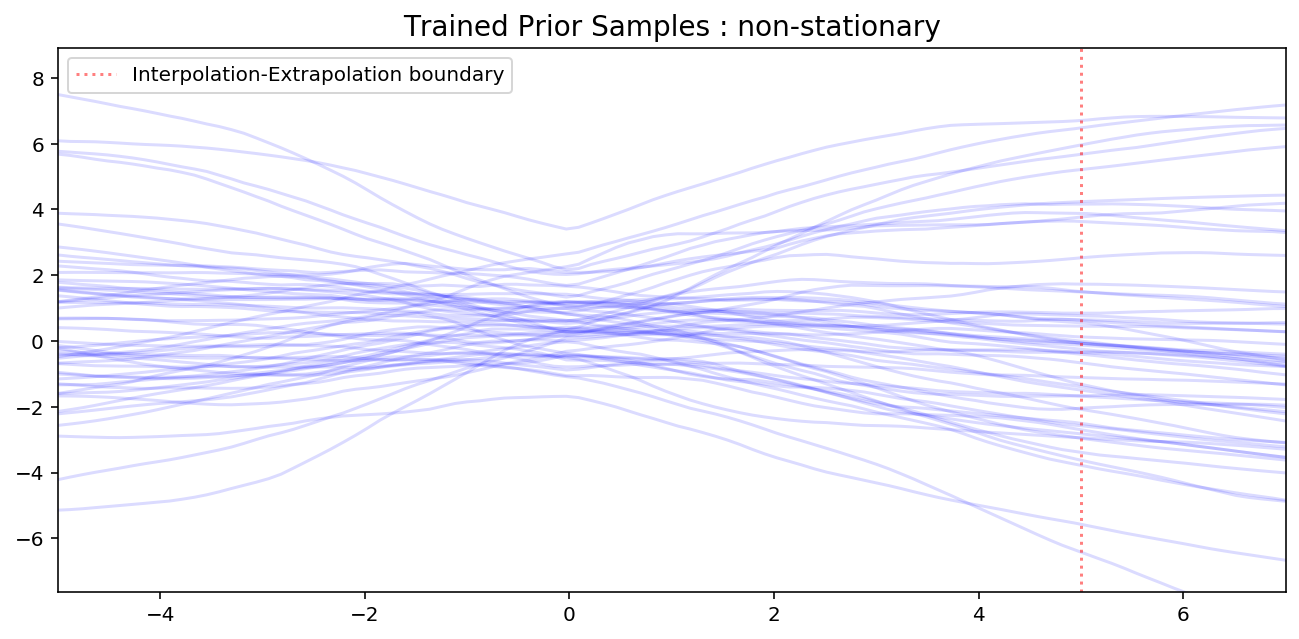

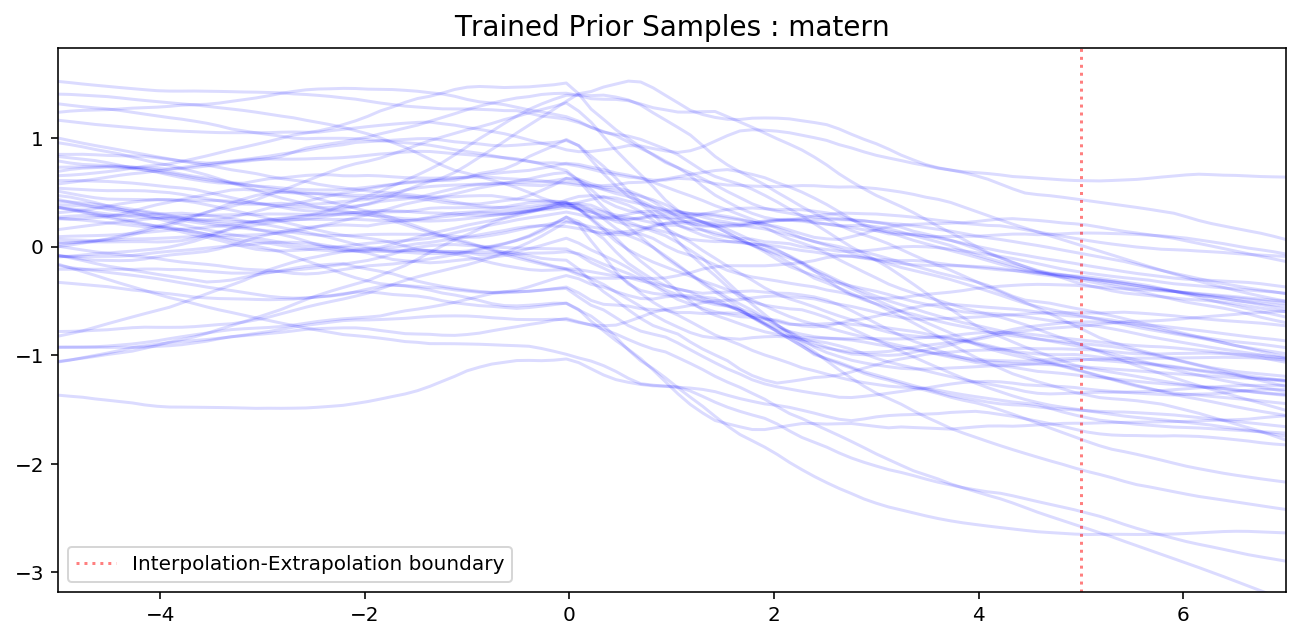

In [21]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

std: 0.47591212391853366
std: 1.089921355247498
std: 3.7150945663452175
std: 1.0422672033309934


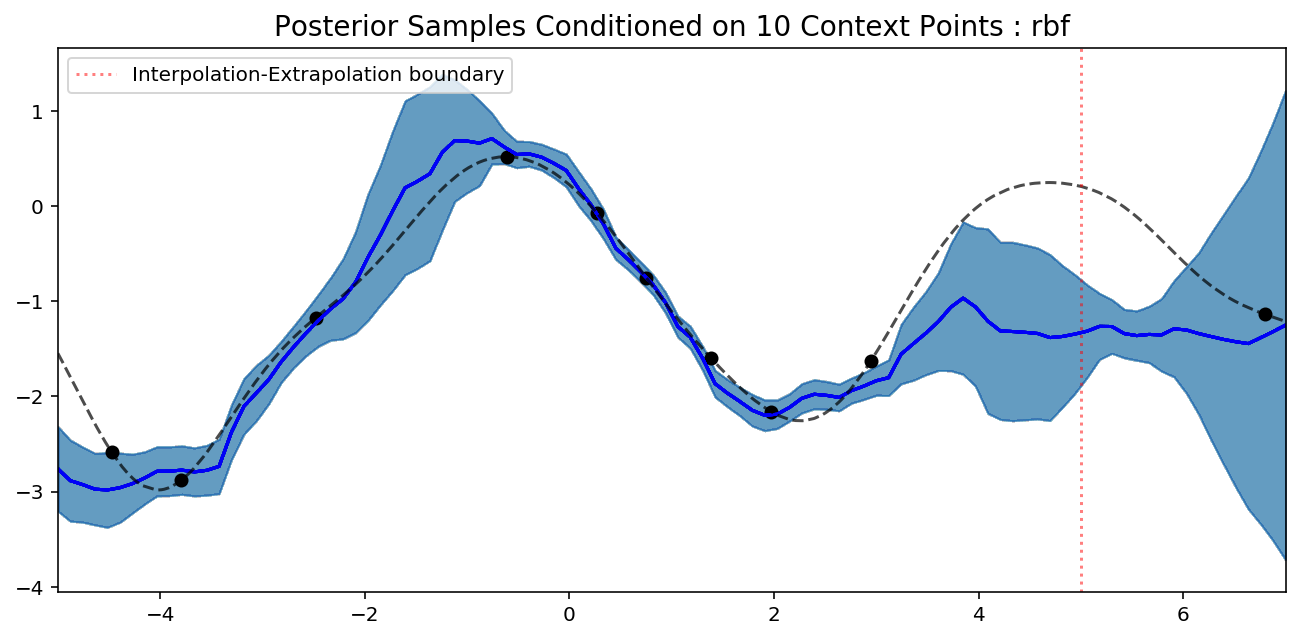

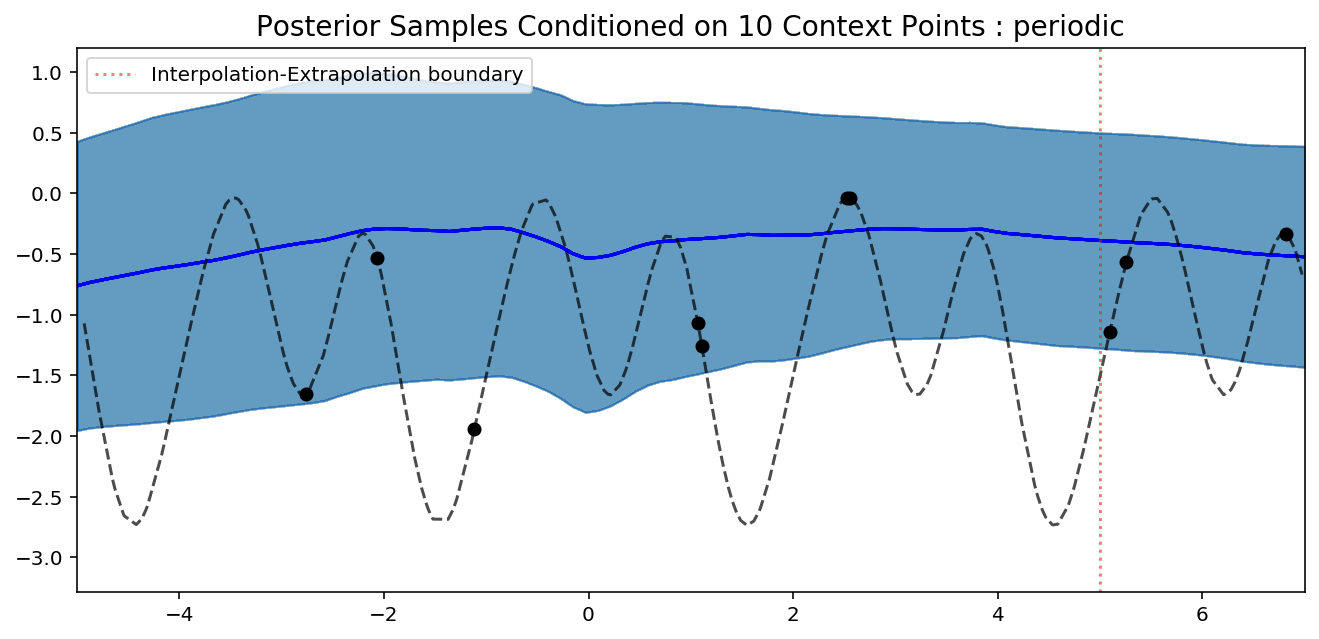

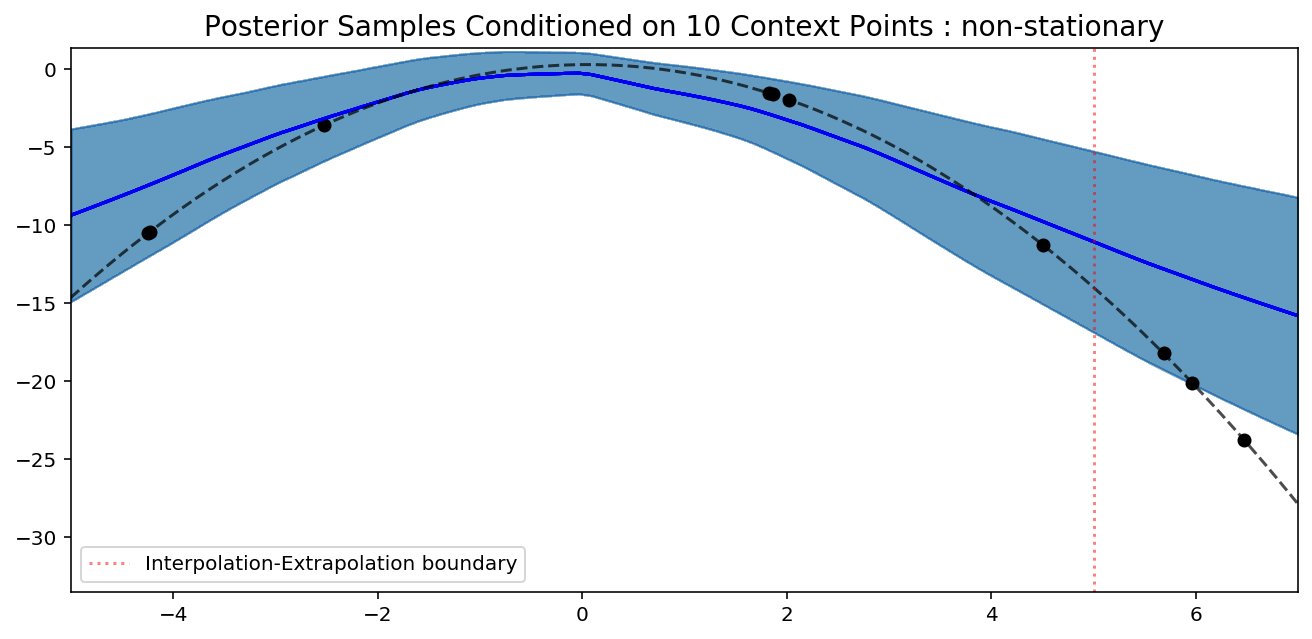

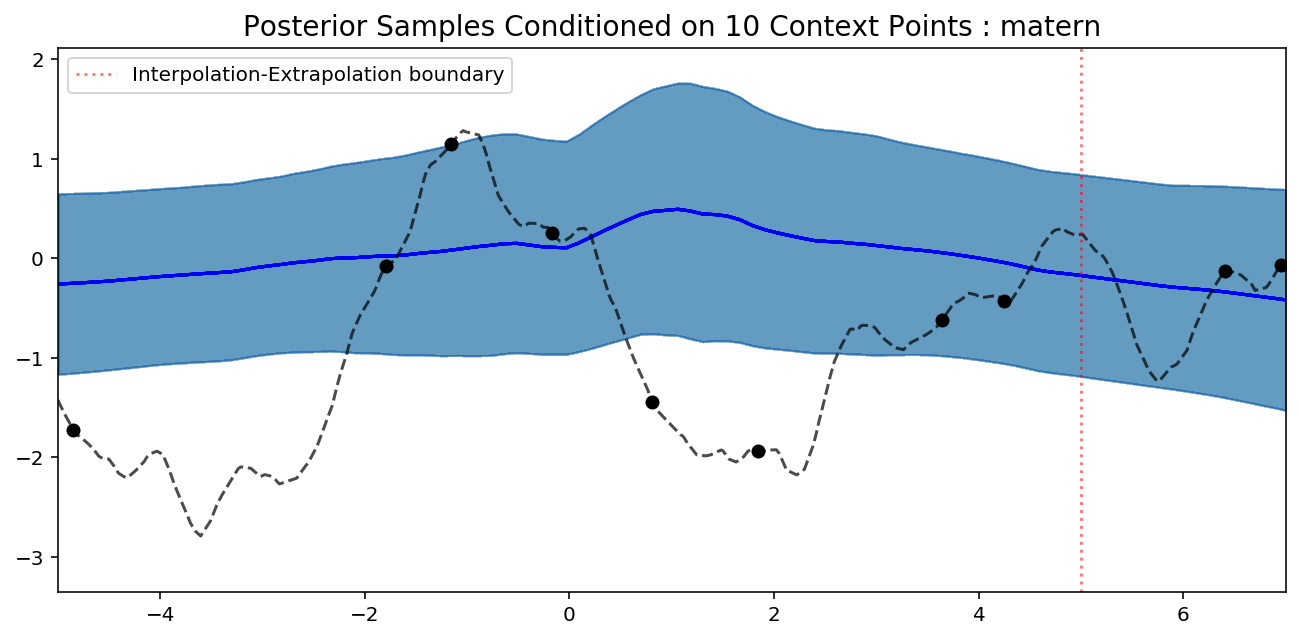

In [22]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 1.0163098573684688
std: 1.0379790067672732
std: 2.3999049663543697
std: 0.888594388961792


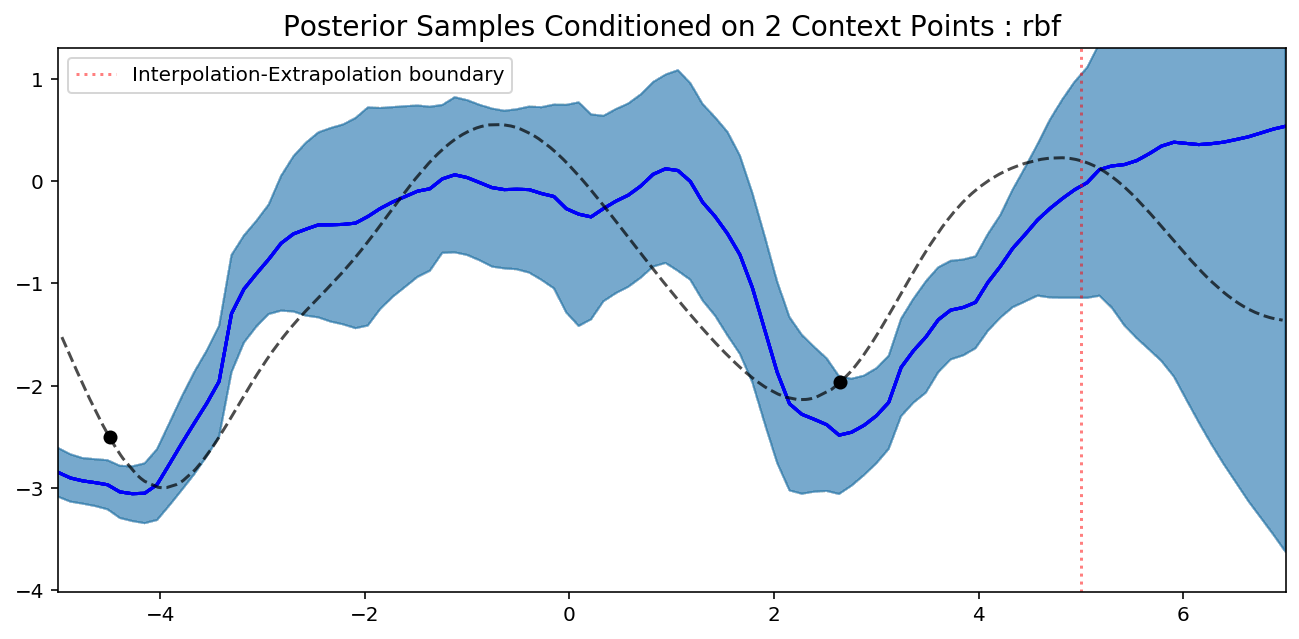

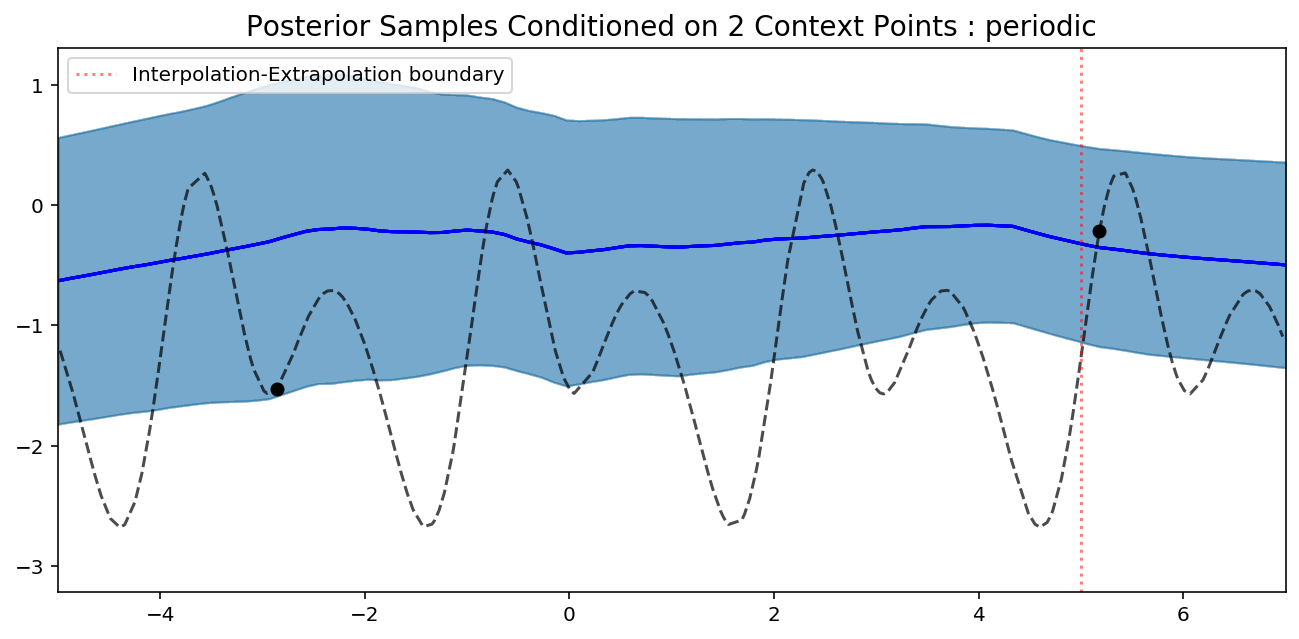

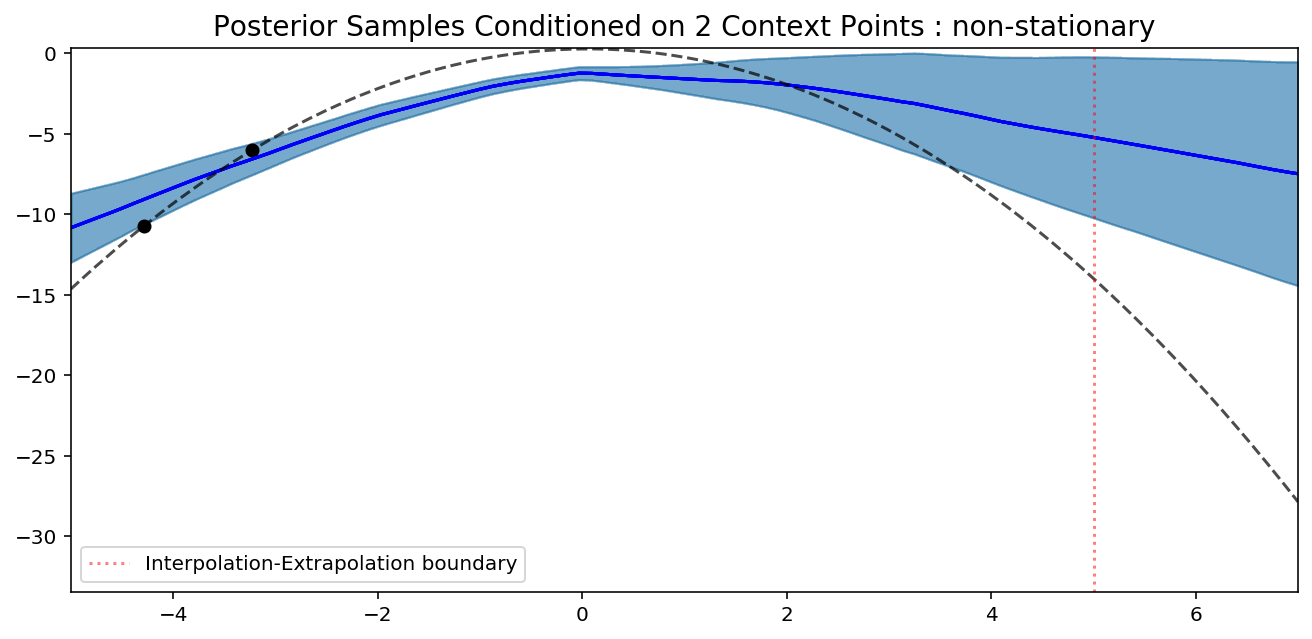

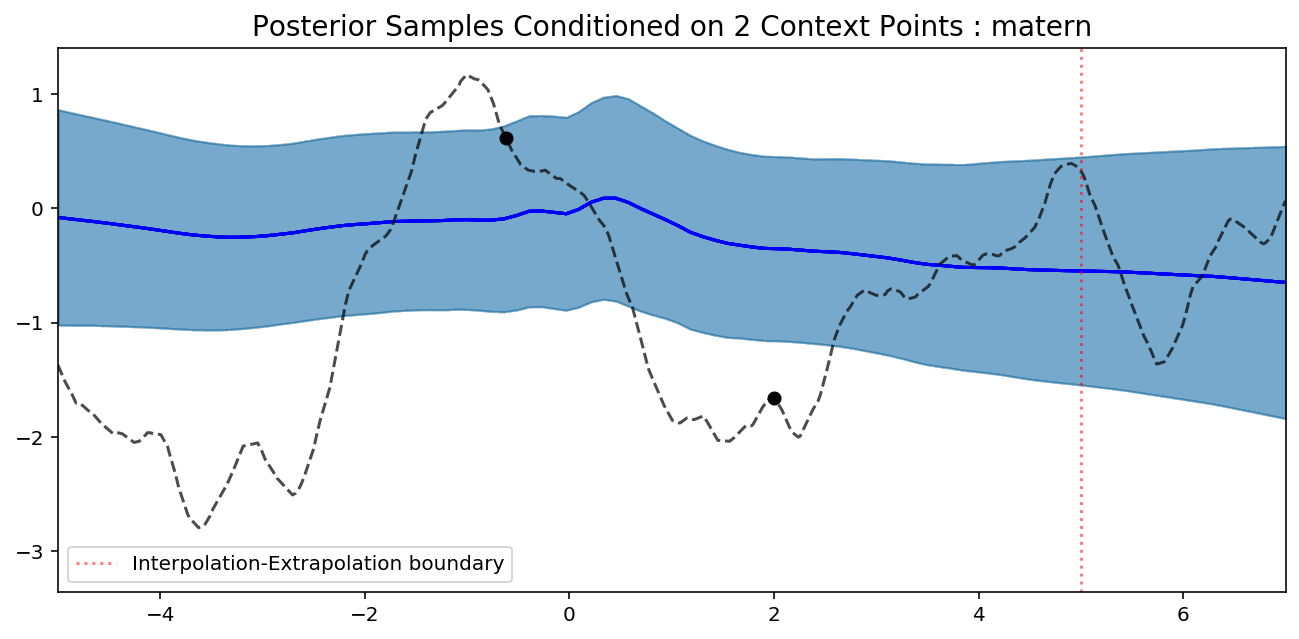

In [23]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=30,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.30801522731780967
std: 0.9218564629554741
std: 2.659605979919433
std: 0.894324243068695


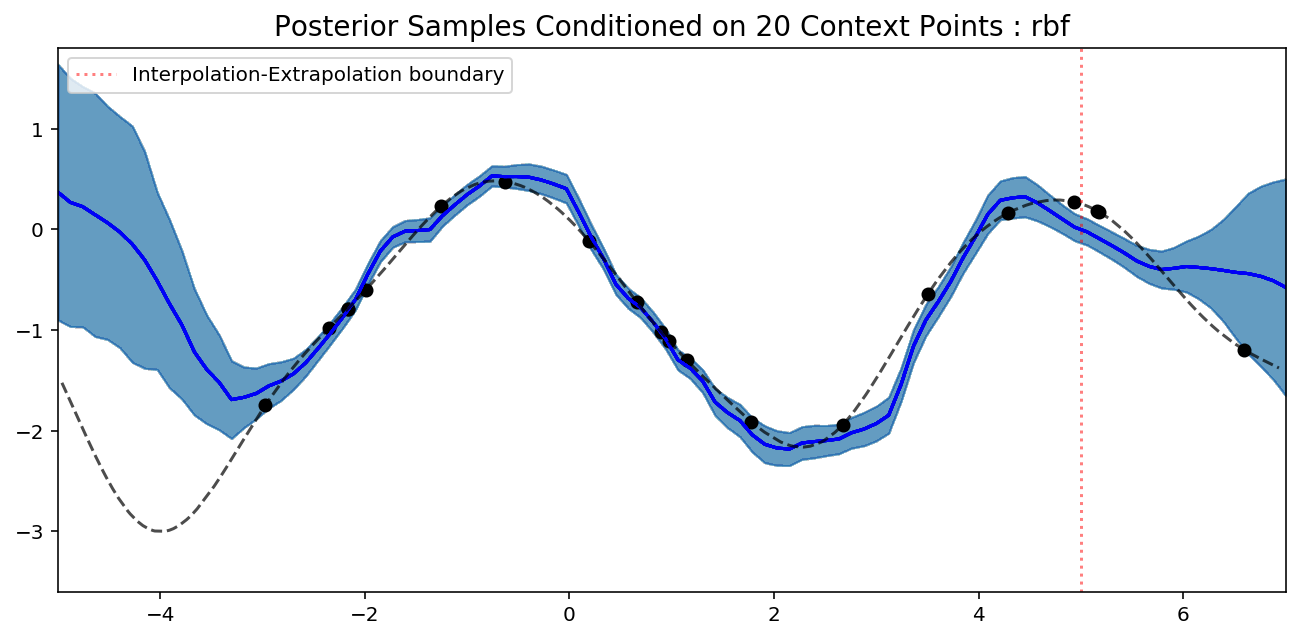

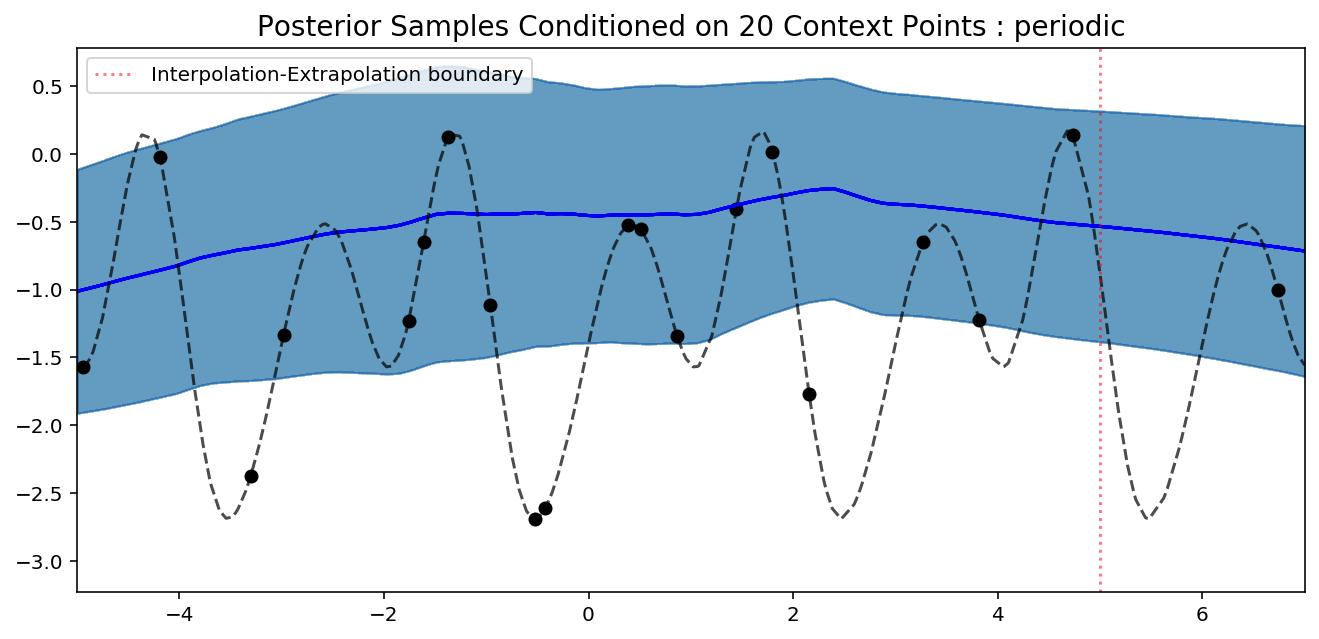

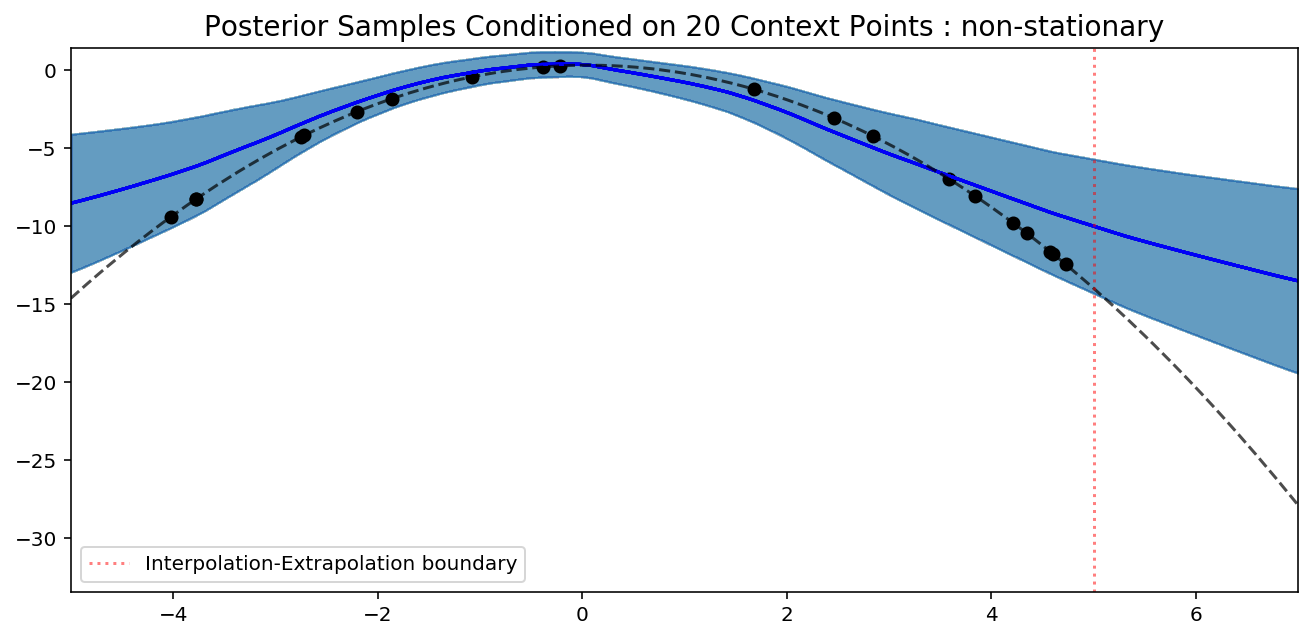

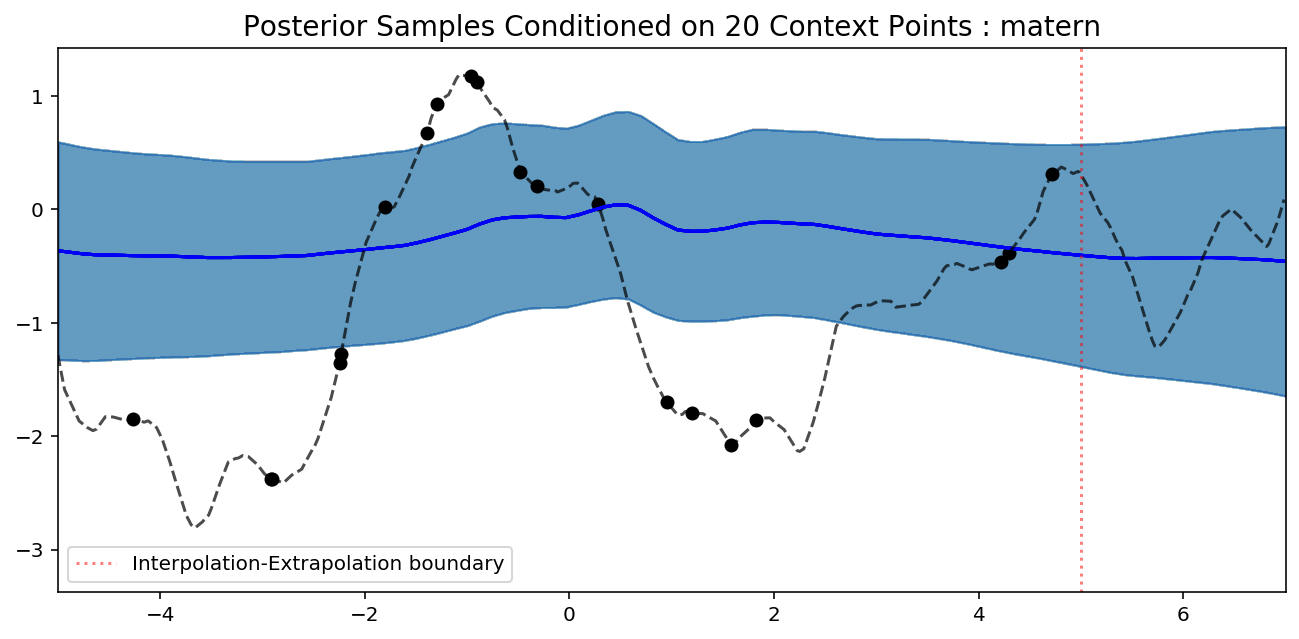

In [24]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))